In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')    

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


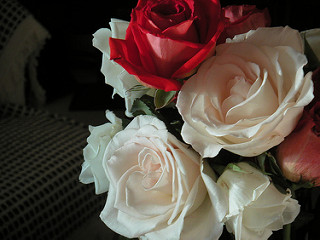

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

In [5]:
batch_size = 32
img_height = 180
img_width = 180

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size)    
    

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


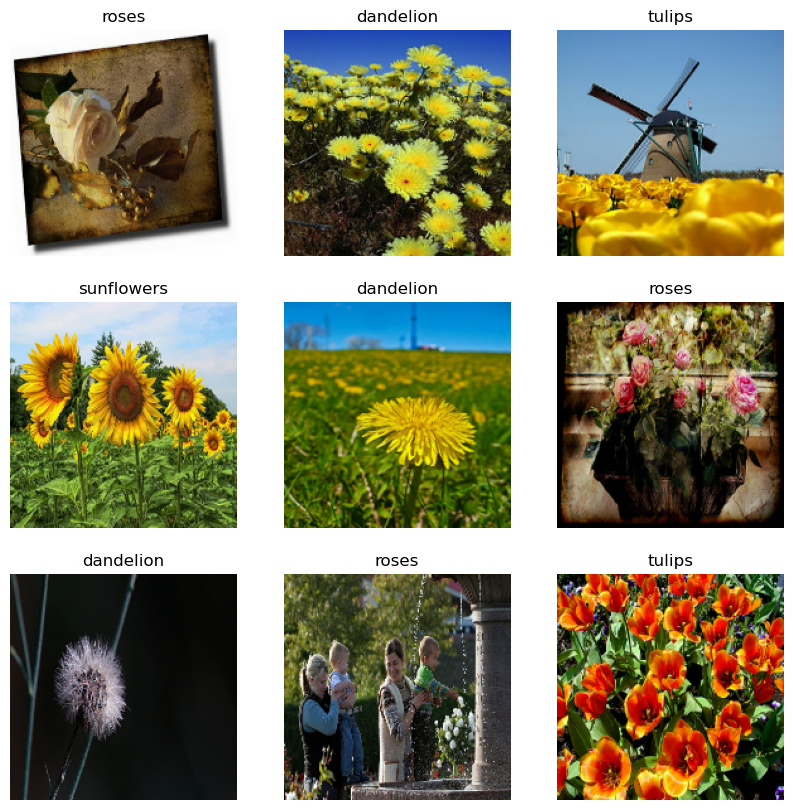

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
            ax = plt.subplot(3,3,i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
                           

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
normalization_layer = layers.Rescaling(1./255)

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 1.0


In [13]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

C:\Users\nahdh\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
epochs=10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 39s 393ms/step - accuracy: 0.4265 - loss: 1.3341 - val_accuracy: 0.5504 - val_loss: 1.0779
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 30s 325ms/step - accuracy: 0.6331 - loss: 0.9466 - val_accuracy: 0.6267 - val_loss: 0.9281
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 30s 325ms/step - accuracy: 0.7111 - loss: 0.7579 - val_accuracy: 0.6621 - val_loss: 0.8509
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 315ms/step - accuracy: 0.8032 - loss: 0.5463 - val_accuracy: 0.6826 - val_loss: 0.8617
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 31s 343ms/step - accuracy: 0.8716 - loss: 0.3793 - val_accuracy: 0.6499 - val_loss: 0.9589
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 314ms/step - accuracy: 0.9266 - loss: 0.2308 - val_accuracy: 0.6894 - val_loss: 1.0050
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 49s 400ms/step - accuracy: 0.9719 - loss: 0.1084 - val_accuracy: 0.6935 - val_loss: 1.1717
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 35s 378ms/step - accuracy: 0.9893 - loss: 0.0523 - val_accu

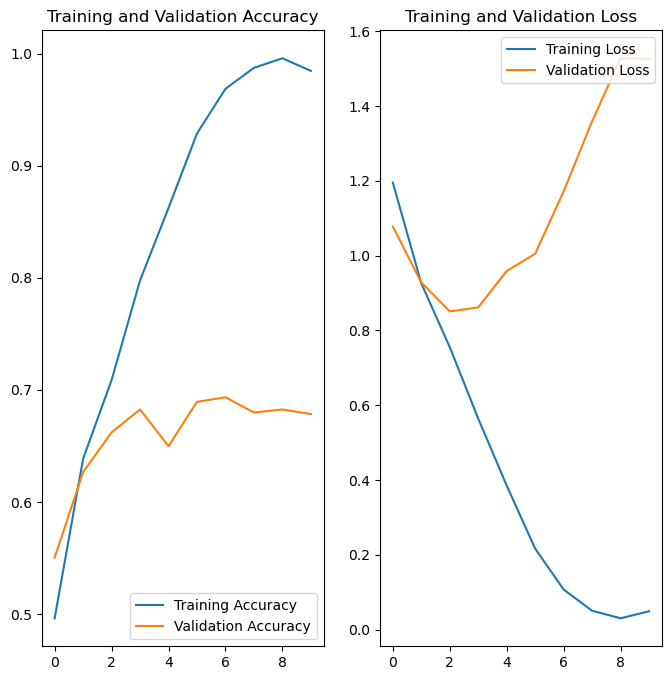

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1) 
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2) 
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [18]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

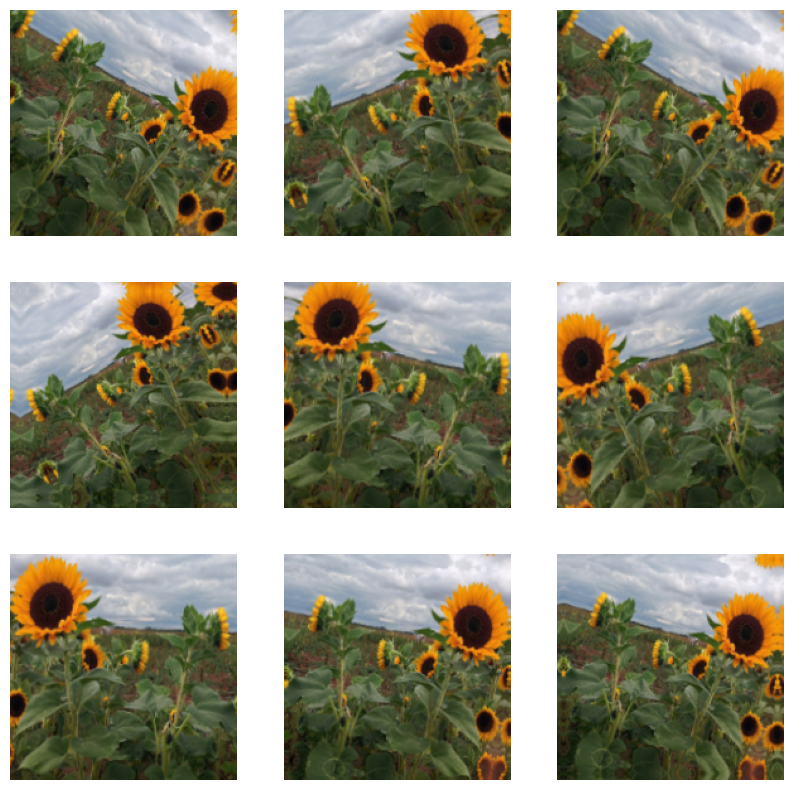

In [19]:
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3,3, i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Dropout Optimization and re training the model

In [20]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name = "outputs")
])

In [21]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ outputs (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [23]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 47s 439ms/step - accuracy: 0.3585 - loss: 1.4456 - val_accuracy: 0.5559 - val_loss: 1.0700
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 451ms/step - accuracy: 0.5911 - loss: 1.0344 - val_accuracy: 0.6172 - val_loss: 1.0021
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 42s 455ms/step - accuracy: 0.6420 - loss: 0.9362 - val_accuracy: 0.6294 - val_loss: 0.9660
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 43s 462ms/step - accuracy: 0.6687 - loss: 0.9003 - val_accuracy: 0.6526 - val_loss: 0.8726
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 86s 506ms/step - accuracy: 0.6889 - loss: 0.8214 - val_accuracy: 0.6703 - val_loss: 0.8253
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 44s 484ms/step - accuracy: 0.6976 - loss: 0.7648 - val_accuracy: 0.6812 - val_loss: 0.8073
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 43s 467ms/step - accuracy: 0.7307 - loss: 0.7112 - val_accuracy: 0.6757 - val_loss: 0.8026
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 46s 506ms/step - accuracy: 0.7397 - loss: 0.6628 - val_accu

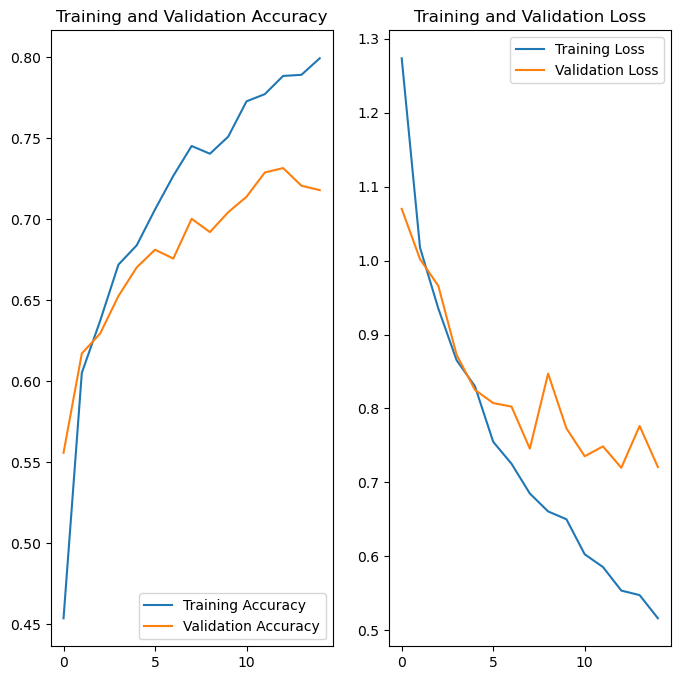

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Predicting new data from the model

In [30]:
sunflower_path = 'PosibleRosa.jpg'

img = tf.keras.utils.load_img(
        sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) #create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
This image most likely belongs to roses with a 91.59 percent confidence.


In [42]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\nahdh\AppData\Local\Temp\tmp2slj61of\assets


INFO:tensorflow:Assets written to: C:\Users\nahdh\AppData\Local\Temp\tmp2slj61of\assets


Saved artifact at 'C:\Users\nahdh\AppData\Local\Temp\tmp2slj61of'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name='keras_tensor_21')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  1886632390736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1886632394576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1886632392272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1886641914704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1886641914128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1886641915472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1886641914512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1886641916240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1886641915280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1886641917008: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [29]:
model.save('flowermodel.keras')

In [44]:
TF_MODEL_FILE_PATH = 'model.tflite' #The default path of the saved TensorFlow model
interpreter = tf.lite.Interpreter(model_path = TF_MODEL_FILE_PATH)

In [45]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['keras_tensor_21'], 'outputs': ['output_0']}}

In [46]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [52]:
predictions_lite = classify_lite(keras_tensor_21=img_array)['output_0']
score_lite = tf.nn.softmax(predictions_lite)

In [53]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to sunflowers with a 98.73 percent confidence.


In [54]:
print(np.max(np.abs(predictions - predictions_lite)))

9.536743e-07
